In [22]:
from qiskit import QuantumCircuit, execute
import matplotlib.pyplot as plt
from qiskit.test.mock import FakeManhattan, FakeBoeblingen, FakeQuito
from qiskit.transpiler import CouplingMap
from qiskit.visualization import plot_gate_map, plot_circuit_layout, plot_histogram
from qiskit.converters import circuit_to_dag
import retworkx as rx
from retworkx.visualization import mpl_draw

In [4]:
from qiskit.transpiler.passes.layout import CSPWCRLayout

/Applications/anaconda3/envs/qiskit-terra-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
from exp.circuit_generators import graphstate_complete

In [6]:
def run_layout_selector_on_circuit(circuit, layout_selector, backend, **kwargs):
    backend_config = backend.configuration()
    coupling_map = CouplingMap(backend_config.coupling_map)
    pass_ = layout_selector(CouplingMap(backend.configuration().coupling_map), **kwargs)
    property_set = {}
    pass_(circuit, property_set)
    circuit._layout = property_set['layout']
    return circuit

def layout_on_circuit(circuit, layout_selector, backend, **kwargs):
    circuit = run_layout_selector_on_circuit(circuit, layout_selector, backend, **kwargs)
    return plot_circuit_layout(circuit, backend)

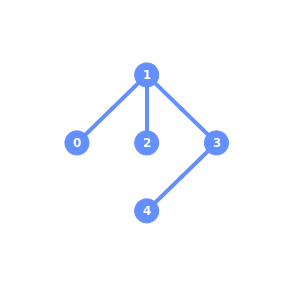

In [7]:
backend = FakeQuito()
plot_gate_map(backend)

In [12]:
coupling_map = CouplingMap(backend.configuration().coupling_map)

In [52]:
def coupling_map_to_coupling_graph(coupling_map):
    cg = rx.PyGraph()

    for edge in coupling_map.get_edges():
        qb1, qb2 = sorted(edge)
        if qb1 not in cg.nodes():
            cg.add_node(qb1)
        if qb2 not in cg.nodes():
            cg.add_node(qb2)
        
        if not cg.has_edge(qb1, qb2):
            cg.add_edge(qb1, qb2, 1)
    return cg

In [53]:
cg_real = coupling_map_to_coupling_graph(coupling_map)

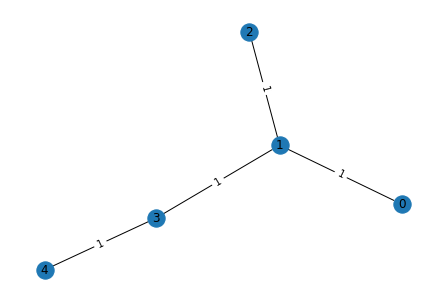

In [54]:
mpl_draw(cg_real, with_labels=True, edge_labels=str)

In [ ]:
def cg_virt_from_matrix(cg_real, adj_matrix, dist_matrix):
    cg_virt = cg_real.copy()
    N, M = adj_matrix.shape()
    for row in range(N):
        for col in range(M):
            if adj_matrix[row, col] == 1 and not cg_virt.has_edge(row, col):
                cg_virt.add_edge(row, col, dist_matrix[row, col])
    return cg_virt

In [36]:
def dag_to_ig(dag):
        """ Creates a interaction map (im) from the dag 
            Input:
                dag (PyDiGraph): The dag
            Returns:
                im (PyDiGraph): The interaction map
        """
        ig = rx.PyGraph()
        
        for qb in dag.qubits:
            ig.add_node(qb)

        # two qubit gates as edges
        for gate in dag.two_qubit_ops():
            qb1, qb2 = sorted([dag.qubits.index(gate.qargs[0]),
                               dag.qubits.index(gate.qargs[1])])
            
            if ig.has_edge(qb1, qb2):
                ig.update_edge(qb1, qb2, ig.get_edge_data(qb1, qb2) + 1)
            else:
                ig.add_edge(qb1, qb2, 1)

        return ig

/Applications/anaconda3/envs/qiskit-terra-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
circuit = graphstate_complete(3)

In [38]:
dag = circuit_to_dag(circuit + circuit)

In [39]:
ig = dag_to_ig(dag)

/Applications/anaconda3/envs/qiskit-terra-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


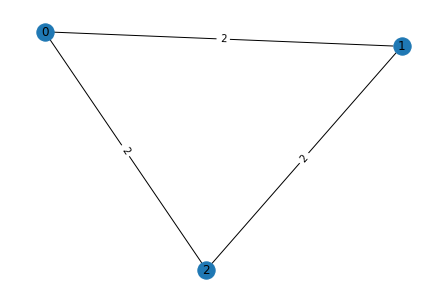

In [41]:
mpl_draw(ig, with_labels=True, edge_labels=str)

In [51]:
rx.is_subgraph_isomorphic(ig, cg)

/Applications/anaconda3/envs/qiskit-terra-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False

list(cm.edge_list())